
# **Recommend Uber Driver’s Lifetime Value in Python**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
driver = pd.read_csv("/content/drive/MyDrive/Data Science_Shubham/Machine learning datasets/GS_Capstone/Uber Lifetime Value/driver_ids.csv")

In [ ]:
ride= pd.read_csv("/content/drive/MyDrive/Data Science_Shubham/Machine learning datasets/GS_Capstone/Uber Lifetime Value/ride_ids.csv")

In [ ]:
ride_timestamps= pd.read_csv("/content/drive/MyDrive/Data Science_Shubham/Machine learning datasets/GS_Capstone/Uber Lifetime Value/ride_timestamps.csv")

Firstly getting the data ready i.e the csv data and setting up the libraries

## Some information about drivers

In [ ]:
driver.head()

driver_id  driver_onboard_date
0  002be0ffdc997bd5c50703158b7c2491  2016-03-29 00:00:00
1  007f0389f9c7b03ef97098422f902e62  2016-03-29 00:00:00
2  011e5c5dfc5c2c92501b8b24d47509bc  2016-04-05 00:00:00
3  0152a2f305e71d26cc964f8d4411add9  2016-04-23 00:00:00
4  01674381af7edd264113d4e6ed55ecda  2016-04-29 00:00:00

In [ ]:
# Print shape (num. of rows, num. of columns)
print('Shape of data: ', driver.shape)

Shape of data:  (937, 2)


In [ ]:
#Print unique number of driver_ids and onboard dates
driver.nunique()

driver_id              937
driver_onboard_date     49
dtype: int64

There are 937 unique drivers.

Print Minimum and Maximum value of driver onboard date


In [ ]:
"Minimum Date: " + driver['driver_onboard_date'].min()

'Minimum Date: 2016-03-28 00:00:00'

In [ ]:
"Maximum Date: " + driver['driver_onboard_date'].max()

'Maximum Date: 2016-05-15 00:00:00'

## Some information about ride_ids data

In [ ]:
ride.head()

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  
0           1811            327               50  
1           3362            809                0  
2           3282            572                0  
3          65283           3338               25  
4           4115            823              100

In [ ]:
# Print shape (num. of rows, num. of columns)
print('Shape of data: ', ride.shape)

Shape of data:  (193502, 5)


In [ ]:
#Print unique number of driver_ids
ride["driver_id"].nunique()

937

There are 937 unique driver_ids.

In [ ]:
#Print unique number of ride_ids
ride["ride_id"].nunique()

193502

There are 193502 unique ride_ids.

In [ ]:
# Print description of numeric values of ride column
ride.describe()

ride_distance  ride_duration  ride_prime_time
count  193502.000000  193502.000000    193502.000000
mean     6955.218266     858.966099        17.305893
std      8929.444606     571.375818        30.825800
min        -2.000000       2.000000         0.000000
25%      2459.000000     491.000000         0.000000
50%      4015.000000     727.000000         0.000000
75%      7193.000000    1069.000000        25.000000
max    724679.000000   28204.000000       500.000000

In [ ]:
ride.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   driver_id        193502 non-null  object
 1   ride_id          193502 non-null  object
 2   ride_distance    193502 non-null  int64 
 3   ride_duration    193502 non-null  int64 
 4   ride_prime_time  193502 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.4+ MB


## Some information about ride_timestamps data



In [ ]:
ride_timestamps.head()

ride_id           event            timestamp
0  00003037a262d9ee40e61b5c0718f7f0    requested_at  2016-06-13 09:39:19
1  00003037a262d9ee40e61b5c0718f7f0     accepted_at  2016-06-13 09:39:51
2  00003037a262d9ee40e61b5c0718f7f0      arrived_at  2016-06-13 09:44:31
3  00003037a262d9ee40e61b5c0718f7f0    picked_up_at  2016-06-13 09:44:33
4  00003037a262d9ee40e61b5c0718f7f0  dropped_off_at  2016-06-13 10:03:05

In [ ]:
# Print shape (num. of rows, num. of columns)
print('Shape of data: ', ride_timestamps.shape)

Shape of data:  (970405, 3)


In [ ]:
#Print unique number of ride_ids
ride_timestamps["ride_id"].nunique()

194081

In [ ]:
#Print count of every value in event column.
ride_timestamps["event"].value_counts()

requested_at      194081
accepted_at       194081
arrived_at        194081
picked_up_at      194081
dropped_off_at    194081
Name: event, dtype: int64

#** Data Engineering**
Calculate the Total Cost of Ride

We calculate the cost per ride using the assumptions from the Uber rate card given:


1.  Base Fare $2.00

1.  Cost per Mile $1.15

1.  Cost per Minute $0.22

1.  Service Fee $1.75

1.  Minimum Fare $5.00

1.  Maximum Fare $400.00


We also apply assumptions regarding applying the Prime Time rate and the Service Fee in line with the actual pricing model of Uber as described in many articles such as this one.

So we calculate it by using this formula:
(base fare+cost per mile×ride_distance+cost per minute×ride_duration)×(1+ride_prime_time100)+service fee

After that, we check if there are any costs less than Minimum Fare, or more than Maximum Fare are change them appropriately, to either Minimum or Maximum Fare respectively.

In [ ]:
# declaring variables

baseFare = 2.00
costPrMile = 1.15
costPrMinute = 0.22
serviceFee = 1.75
minFare = 5.00
maxFare = 400.00




In [ ]:
ride.head()

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  
0           1811            327               50  
1           3362            809                0  
2           3282            572                0  
3          65283           3338               25  
4           4115            823              100


Where condition True, yield x, otherwise yield y.


np.where(condition, x (if condition is true x is returned) , y(if condition is false y is returned))

In [ ]:
# Create a new column for ride total cost using the formula given above
# Also convert distance to miles and ride_duration from seconds to minutes

ride['ride_total_cost']= (baseFare + costPrMile*ride["ride_distance"]*0.000621 +
                          costPrMinute*ride["ride_duration"]*0.0166667)* (1 + ride["ride_prime_time"]/100) + serviceFee


# Apply lower and upper bound to ride cost (Minimum Fare, Maximum Fare )


ride['ride_total_cost'] = np.where(ride['ride_total_cost'] < minFare, minFare, ride['ride_total_cost'])
ride['ride_total_cost'] = np.where(ride['ride_total_cost'] > maxFare, maxFare, ride['ride_total_cost'])





In [ ]:
ride.head(3)

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   

   ride_distance  ride_duration  ride_prime_time  ride_total_cost  
0           1811            327               50         8.488492  
1           3362            809                0         9.117312  
2           3282            572                0         8.191178

In [ ]:
ride_timestamps.head()

ride_id           event            timestamp
0  00003037a262d9ee40e61b5c0718f7f0    requested_at  2016-06-13 09:39:19
1  00003037a262d9ee40e61b5c0718f7f0     accepted_at  2016-06-13 09:39:51
2  00003037a262d9ee40e61b5c0718f7f0      arrived_at  2016-06-13 09:44:31
3  00003037a262d9ee40e61b5c0718f7f0    picked_up_at  2016-06-13 09:44:33
4  00003037a262d9ee40e61b5c0718f7f0  dropped_off_at  2016-06-13 10:03:05

As we can see the events data is very clustered and has lot of repetitons of ride_id in the ride_timestamps table.
we'll pivot to make it more organized


pivot and pivot table are two different concepts

In [ ]:
ride_events = ride_timestamps.pivot(index="ride_id" ,columns='event', values="timestamp")
ride_events.head()

event                                     accepted_at           arrived_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:51  2016-06-13 09:44:31   
00005eae40882760d675da5effb89ae3  2016-05-14 05:23:25  2016-05-14 05:26:17   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:43:14  2016-05-16 15:47:29   
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:29:43  2016-05-11 19:35:11   
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:12:15  2016-04-26 18:16:52   

event                                  dropped_off_at         picked_up_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 10:03:05  2016-06-13 09:44:33   
00005eae40882760d675da5effb89ae3  2016-05-14 05:34:17  2016-05-14 05:26:18   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:54:18  2016-05-16 15:47:32   
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:40:47  2016-05-11 19:35:15   
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:24:14  2016-04-26 18:16:55   

event                                    requested_at  
ride_id                                                
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:19  
00005eae40882760d675da5effb89ae3  2016-05-14 05:23:21  
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:43:09  
00006efeb0d5e3ccad7d921ddeee9900  2016-05-11 19:29:36  
0000d9b24d8ccdd991b76258e616fa01  2016-04-26 18:11:38

In [ ]:
# Merging ride and ride_events data into ride_merg

ride_merg= pd.merge(ride, ride_events, on="ride_id")
ride_merg.head()

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  ride_total_cost  \
0           1811            327               50         8.488492   
1           3362            809                0         9.117312   
2           3282            572                0         8.191178   
3          65283           3338               25        77.826515   
4           4115            823              100        17.662800   

           accepted_at           arrived_at       dropped_off_at  \
0  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   
3  2016-05-19 09:15:33  2016-05-19 09:18:20  2016-05-19 10:13:58   
4  2016-04-20 22:05:32  2016-04-20 22:07:03  2016-04-20 22:20:45   

          picked_up_at         requested_at  
0  2016-04-23 02:16:40  2016-04-23 02:13:50  
1  2016-03-29 19:04:01  2016-03-29 19:00:49  
2  2016-06-21 12:01:35  2016-06-21 11:56:31  
3  2016-05-19 09:18:20  2016-05-19 09:15:29  
4  2016-04-20 22:07:02  2016-04-20 22:05:30

In [ ]:
# convert ride distance from meters to kilometers
ride_merg['ride_distance'] =  ride_merg['ride_distance']/1000
# convert ride duration from seconds to minutes
ride_merg['ride_duration'] = ride_merg['ride_duration']/60

# Create some Features
# It is the time a driver takes to accept a ride once it is requested in minutes.
ride_merg["accept_response_time"] = (pd.to_datetime(ride_merg['accepted_at']) - pd.to_datetime( ride_merg['requested_at'] )).astype('timedelta64[s]')/60

# It is the time a driver takes to reach the pickup location once a ride is accepted in minutes.
ride_merg["arrival_time"] =(pd.to_datetime(ride_merg['arrived_at']) -pd.to_datetime( ride_merg['accepted_at'])).astype('timedelta64[s]')/60

# It is the time a driver waits for the rider once the driver reaches the pickup location in minutes.
ride_merg["waiting_time"] = (pd.to_datetime( ride_merg['picked_up_at'])- pd.to_datetime(ride_merg['arrived_at'] )).astype('timedelta64[s]')/60


# divide ride distance to 3 categories (Short ride, medium ride, long ride) dependant on ride_distance column (KM)

ride_merg["ride_type"] = np.where(ride_merg['ride_distance'] > ride_merg['ride_distance'].quantile(0.33), (np.where(ride_merg['ride_distance'] < ride_merg['ride_distance'].quantile(0.66),"med_ride", "long_ride")), "short_ride")


# divide ride time to 3 categories (Morning ride, evening ride, night ride) dependant on accepted_at column (time)





# Convert accepted_at column to date

ride_merg['ride_date']=pd.to_datetime(ride_merg['accepted_at']).dt.date



ride_merg['ride_time'] =np.where( pd.to_datetime(ride_merg['accepted_at']).dt.hour > 6, (np.where(pd.to_datetime(ride_merg['accepted_at']).dt.hour <=15 ,"morning_ride" , (np.where(pd.to_datetime(ride_merg['accepted_at']).dt.hour <=21,"evening_ride", "night_ride")) )), "night_ride")


# Print first 3 rows in ride data




ride_merg.head()

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  ride_total_cost  \
0          1.811       5.450000               50         8.488492   
1          3.362      13.483333                0         9.117312   
2          3.282       9.533333                0         8.191178   
3         65.283      55.633333               25        77.826515   
4          4.115      13.716667              100        17.662800   

           accepted_at           arrived_at       dropped_off_at  \
0  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   
3  2016-05-19 09:15:33  2016-05-19 09:18:20  2016-05-19 10:13:58   
4  2016-04-20 22:05:32  2016-04-20 22:07:03  2016-04-20 22:20:45   

          picked_up_at         requested_at  accept_response_time  \
0  2016-04-23 02:16:40  2016-04-23 02:13:50              0.416667   
1  2016-03-29 19:04:01  2016-03-29 19:00:49              0.050000   
2  2016-06-21 12:01:35  2016-06-21 11:56:31              0.133333   
3  2016-05-19 09:18:20  2016-05-19 09:15:29              0.066667   
4  2016-04-20 22:07:02  2016-04-20 22:05:30              0.033333   

   arrival_time  waiting_time   ride_type   ride_date     ride_time  
0      2.350000      0.066667  short_ride  2016-04-23    night_ride  
1      3.083333      0.066667    med_ride  2016-03-29  evening_ride  
2      4.883333      0.050000    med_ride  2016-06-21  morning_ride  
3      2.783333      0.000000   long_ride  2016-05-19  morning_ride  
4      1.516667     -0.016667    med_ride  2016-04-20    night_ride

In [ ]:
ride_merg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184819 entries, 0 to 184818
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   driver_id             184819 non-null  object 
 1   ride_id               184819 non-null  object 
 2   ride_distance         184819 non-null  float64
 3   ride_duration         184819 non-null  float64
 4   ride_prime_time       184819 non-null  int64  
 5   ride_total_cost       184819 non-null  float64
 6   accepted_at           184819 non-null  object 
 7   arrived_at            184818 non-null  object 
 8   dropped_off_at        184819 non-null  object 
 9   picked_up_at          184819 non-null  object 
 10  requested_at          184819 non-null  object 
 11  accept_response_time  184819 non-null  float64
 12  arrival_time          184818 non-null  float64
 13  waiting_time          184818 non-null  float64
 14  ride_type             184819 non-null  object 
 15  

<Axes: xlabel='ride_type', ylabel='Count'>

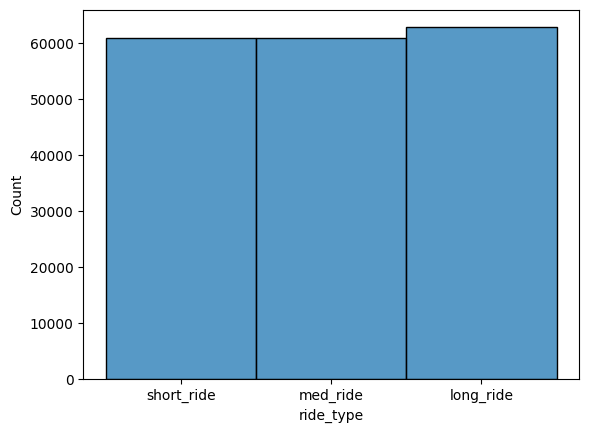

In [ ]:
# histogram of ride length categories

sns.histplot(ride_merg['ride_type'])


# Create Features of the Drivers

In [ ]:
ride_merg.head()

driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  ride_total_cost  \
0          1.811       5.450000               50         8.488492   
1          3.362      13.483333                0         9.117312   
2          3.282       9.533333                0         8.191178   
3         65.283      55.633333               25        77.826515   
4          4.115      13.716667              100        17.662800   

           accepted_at           arrived_at       dropped_off_at  \
0  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   
3  2016-05-19 09:15:33  2016-05-19 09:18:20  2016-05-19 10:13:58   
4  2016-04-20 22:05:32  2016-04-20 22:07:03  2016-04-20 22:20:45   

          picked_up_at         requested_at  accept_response_time  \
0  2016-04-23 02:16:40  2016-04-23 02:13:50              0.416667   
1  2016-03-29 19:04:01  2016-03-29 19:00:49              0.050000   
2  2016-06-21 12:01:35  2016-06-21 11:56:31              0.133333   
3  2016-05-19 09:18:20  2016-05-19 09:15:29              0.066667   
4  2016-04-20 22:07:02  2016-04-20 22:05:30              0.033333   

   arrival_time  waiting_time   ride_type   ride_date     ride_time  
0      2.350000      0.066667  short_ride  2016-04-23    night_ride  
1      3.083333      0.066667    med_ride  2016-03-29  evening_ride  
2      4.883333      0.050000    med_ride  2016-06-21  morning_ride  
3      2.783333      0.000000   long_ride  2016-05-19  morning_ride  
4      1.516667     -0.016667    med_ride  2016-04-20    night_ride

In [ ]:
# calculate driver_perday_ridecount


kk= ride_merg.pivot_table(index="driver_id", columns="ride_date" ,aggfunc='size').fillna(0)
kk

ride_date                         2016-03-28  2016-03-29  2016-03-30  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         0.0         6.0         0.0   
007f0389f9c7b03ef97098422f902e62         0.0         1.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9         0.0         0.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0         0.0         0.0   
...                                      ...         ...         ...   
ff419a3476e21e269e340b5f1f05414e         0.0         0.0         0.0   
ff714a67ba8c6a108261cd81e3b77f3a        16.0         3.0        13.0   
fff482c704d36a1afe8b8978d5486283         0.0         0.0         0.0   
fffecccc49436c5389075b13209f0dfa         0.0         0.0         0.0   
ffff51a71f2f185ec5e97d59dbcd7a78         0.0         0.0         0.0   

ride_date                         2016-03-31  2016-04-01  2016-04-02  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         8.0         7.0         5.0   
007f0389f9c7b03ef97098422f902e62         0.0         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9         0.0         0.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0         0.0         0.0   
...                                      ...         ...         ...   
ff419a3476e21e269e340b5f1f05414e         0.0         0.0         0.0   
ff714a67ba8c6a108261cd81e3b77f3a        10.0        11.0         5.0   
fff482c704d36a1afe8b8978d5486283         0.0         0.0         0.0   
fffecccc49436c5389075b13209f0dfa         0.0         0.0         0.0   
ffff51a71f2f185ec5e97d59dbcd7a78         0.0         0.0         0.0   

ride_date                         2016-04-03  2016-04-04  2016-04-05  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         0.0         0.0         7.0   
007f0389f9c7b03ef97098422f902e62         0.0         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         0.0         0.0         2.0   
0152a2f305e71d26cc964f8d4411add9         0.0         0.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0         0.0         0.0   
...                                      ...         ...         ...   
ff419a3476e21e269e340b5f1f05414e         0.0         0.0         0.0   
ff714a67ba8c6a108261cd81e3b77f3a         0.0         4.0         1.0   
fff482c704d36a1afe8b8978d5486283         0.0         0.0         0.0   
fffecccc49436c5389075b13209f0dfa         0.0         0.0         0.0   
ffff51a71f2f185ec5e97d59dbcd7a78         0.0         0.0         0.0   

ride_date                         2016-04-06  ...  2016-06-17  2016-06-18  \
driver_id                                     ...                           
002be0ffdc997bd5c50703158b7c2491         0.0  ...         1.0         3.0   
007f0389f9c7b03ef97098422f902e62         0.0  ...         0.0         0.0   
011e5c5dfc5c2c92501b8b24d47509bc         3.0  ...         0.0         0.0   
0152a2f305e71d26cc964f8d4411add9         0.0  ...         4.0         0.0   
01674381af7edd264113d4e6ed55ecda         0.0  ...         8.0         0.0   
...                                      ...  ...         ...         ...   
ff419a3476e21e269e340b5f1f05414e         0.0  ...         5.0         0.0   
ff714a67ba8c6a108261cd81e3b77f3a         5.0  ...         6.0         0.0   
fff482c704d36a1afe8b8978d5486283         0.0  ...         0.0         0.0   
fffecccc49436c5389075b13209f0dfa         0.0  ...         9.0        10.0   
ffff51a71f2f185ec5e97d59dbcd7a78         0.0  ...         0.0         5.0   

ride_date                         2016-06-19  2016-06-20  2016-06-21  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         0.

In [ ]:
driver_info = pd.DataFrame()
# Calc. driver total ride count

driver_info['total_ride_count'] = ride_merg.pivot_table(index="driver_id", aggfunc='size')

# Calc. driver total ride distance
driver_info['total_ride_distance'] = ride.groupby('driver_id')['ride_distance'].sum()

# Calc. driver total ride duration

driver_info['total_ride_duration'] = ride.groupby('driver_id')['ride_duration'].sum()

# Calc. driver lifetime value (total revenue)

driver_info['driver_lifetime_val'] =  ride.groupby('driver_id')['ride_total_cost'].sum()

# Calc. mean driver count ride per day

driver_info['perday_ridecount_mean'] = kk.mean(axis=1)

# Calc. mean of ride accept responce time for every driver

driver_info['accept_resp_time_mean'] =  ride_merg.groupby('driver_id')['accept_response_time'].mean()

# Calc. mean of ride arrival time for every driver

driver_info['arrival_time_mean'] = ride_merg.groupby('driver_id')['arrival_time'].mean()

# Calc. mean of ride wait time for every driver

driver_info['driver_wait_time_mean'] = ride_merg.groupby('driver_id')['waiting_time'].mean()


# count total no. of short/medium/long evening rides

driver_info = pd.merge(driver_info, ride_merg.pivot_table(index = 'driver_id', columns = 'ride_type', aggfunc='size') ,on='driver_id')


# count total no. of day/night/night evening rides

driver_info = pd.merge(driver_info, ride_merg.pivot_table(index = 'driver_id', columns = 'ride_time', aggfunc='size') ,on='driver_id')


# fill nan value with 0
driver_info.fillna(0)
driver_info.head(5)


total_ride_count  total_ride_distance  \
driver_id                                                                 
002be0ffdc997bd5c50703158b7c2491               277              1740287   
007f0389f9c7b03ef97098422f902e62                31               117531   
011e5c5dfc5c2c92501b8b24d47509bc                34               269653   
0152a2f305e71d26cc964f8d4411add9               191              1471239   
01674381af7edd264113d4e6ed55ecda               375              3123644   

                                  total_ride_duration  driver_lifetime_val  \
driver_id                                                                    
002be0ffdc997bd5c50703158b7c2491               221238          3560.058574   
007f0389f9c7b03ef97098422f902e62                20497           321.434883   
011e5c5dfc5c2c92501b8b24d47509bc                29205           482.299458   
0152a2f305e71d26cc964f8d4411add9               174521          2610.190490   
01674381af7edd264113d4e6ed55ecda               357443          5379.647779   

                                  perday_ridecount_mean  \
driver_id                                                 
002be0ffdc997bd5c50703158b7c2491               3.043956   
007f0389f9c7b03ef97098422f902e62               0.340659   
011e5c5dfc5c2c92501b8b24d47509bc               0.373626   
0152a2f305e71d26cc964f8d4411add9               2.098901   
01674381af7edd264113d4e6ed55ecda               4.120879   

                                  accept_resp_time_mean  arrival_time_mean  \
driver_id                                                                    
002be0ffdc997bd5c50703158b7c2491               0.140132           2.883153   
007f0389f9c7b03ef97098422f902e62               0.197312           2.952688   
011e5c5dfc5c2c92501b8b24d47509bc               0.121569           3.720588   
0152a2f305e71d26cc964f8d4411add9               0.236649           3.908813   
01674381af7edd264113d4e6ed55ecda               0.208800           3.608133   

                                  driver_wait_time_mean  long_ride  med_ride  \
driver_id                                                                      
002be0ffdc997bd5c50703158b7c2491               0.087184         79       103   
007f0389f9c7b03ef97098422f902e62               0.081183          5        15   
011e5c5dfc5c2c92501b8b24d47509bc               0.068137         11        11   
0152a2f305e71d26cc964f8d4411add9               0.091885         99        51   
01674381af7edd264113d4e6ed55ecda               0.136800        157       111   

                                  short_ride  evening_ride  morning_ride  \
driver_id                                                                  
002be0ffdc997bd5c50703158b7c2491          95         103.0          85.0   
007f0389f9c7b03ef97098422f902e62          11          24.0           6.0   
011e5c5dfc5c2c92501b8b24d47509bc          12          24.0           8.0   
0152a2f305e71d26cc964f8d4411add9          41          17.0          67.0   
01674381af7edd264113d4e6ed55ecda         107           NaN         350.0   

                                  night_ride  
driver_id                                     
002be0ffdc997bd5c50703158b7c2491        89.0  
007f0389f9c7b03ef97098422f902e62         1.0  
011e5c5dfc5c2c92501b8b24d47509bc         2.0  
0152a2f305e71d26cc964f8d4411add9       107.0  
01674381af7edd264113d4e6ed55ecda        25.0

In [ ]:
onboard_data = pd.merge(ride_merg.groupby('driver_id').agg({'accepted_at': max}),driver,on ="driver_id")



onboard_data['driver_duration'] = (pd.to_datetime(onboard_data['accepted_at']) -pd.to_datetime(onboard_data['driver_onboard_date'])).astype('timedelta64[D]')



onboard_data=onboard_data[['driver_id','driver_duration']]


onboard_data.head()

driver_id  driver_duration
0  002be0ffdc997bd5c50703158b7c2491             86.0
1  007f0389f9c7b03ef97098422f902e62             85.0
2  011e5c5dfc5c2c92501b8b24d47509bc             68.0
3  0152a2f305e71d26cc964f8d4411add9             64.0
4  01674381af7edd264113d4e6ed55ecda             56.0

In [ ]:
driver_info=pd.merge(driver_info, onboard_data , on='driver_id', how='inner')
driver_info.head()

driver_id  total_ride_count  total_ride_distance  \
0  002be0ffdc997bd5c50703158b7c2491               277              1740287   
1  007f0389f9c7b03ef97098422f902e62                31               117531   
2  011e5c5dfc5c2c92501b8b24d47509bc                34               269653   
3  0152a2f305e71d26cc964f8d4411add9               191              1471239   
4  01674381af7edd264113d4e6ed55ecda               375              3123644   

   total_ride_duration  driver_lifetime_val  perday_ridecount_mean  \
0               221238          3560.058574               3.043956   
1                20497           321.434883               0.340659   
2                29205           482.299458               0.373626   
3               174521          2610.190490               2.098901   
4               357443          5379.647779               4.120879   

   accept_resp_time_mean  arrival_time_mean  driver_wait_time_mean  long_ride  \
0               0.140132           2.883153               0.087184         79   
1               0.197312           2.952688               0.081183          5   
2               0.121569           3.720588               0.068137         11   
3               0.236649           3.908813               0.091885         99   
4               0.208800           3.608133               0.136800        157   

   med_ride  short_ride  evening_ride  morning_ride  night_ride  \
0       103          95         103.0          85.0        89.0   
1        15          11          24.0           6.0         1.0   
2        11          12          24.0           8.0         2.0   
3        51          41          17.0          67.0       107.0   
4       111         107           NaN         350.0        25.0   

   driver_duration  
0             86.0  
1             85.0  
2             68.0  
3             64.0  
4             56.0

#  **Exploratory Analysis**

In [ ]:
driver_info.describe()

total_ride_count  total_ride_distance  total_ride_duration  \
count        837.000000         8.370000e+02           837.000000   
mean         220.082437         1.528516e+06        189242.789725   
std          178.180347         1.259931e+06        154009.144305   
min            3.000000         9.895000e+03          1712.000000   
25%           44.000000         3.390140e+05         38363.000000   
50%          224.000000         1.451389e+06        189906.000000   
75%          330.000000         2.311846e+06        288097.000000   
max          919.000000         6.628201e+06        779797.000000   

       driver_lifetime_val  perday_ridecount_mean  accept_resp_time_mean  \
count           837.000000             837.000000             837.000000   
mean           2979.105443               2.418488               0.198516   
std            2416.299475               1.958026               0.069286   
min              25.687099               0.032967               0.084074   
25%             618.061127               0.483516               0.158730   
50%            2958.452290               2.461538               0.184409   
75%            4475.230584               3.626374               0.221540   
max           12347.109505              10.098901               0.687500   

       arrival_time_mean  driver_wait_time_mean   long_ride    med_ride  \
count         837.000000             837.000000  837.000000  837.000000   
mean            4.417544               0.064720   74.874552   72.569892   
std             1.406403               0.127561   60.894880   60.813653   
min             1.668056              -1.387415    1.000000    1.000000   
25%             3.458333               0.034524   18.000000   14.000000   
50%             4.104848               0.059024   71.000000   72.000000   
75%             5.042160               0.115833  114.000000  111.000000   
max            12.045238               0.491954  335.000000  294.000000   

       short_ride  evening_ride  morning_ride  night_ride  driver_duration  
count  837.000000    825.000000    795.000000  745.000000       837.000000  
mean    72.637993     86.109091     89.677987   56.208054        55.075269  
std     62.422290     81.631930     92.331196   66.259598        21.721934  
min      1.000000      1.000000      1.000000    1.000000         1.000000  
25%     14.000000     18.000000     19.000000   10.000000        42.000000  
50%     72.000000     62.000000     53.000000   29.000000        57.000000  
75%    112.000000    141.000000    142.000000   85.000000        73.000000  
max    313.000000    404.000000    515.000000  470.000000        90.000000

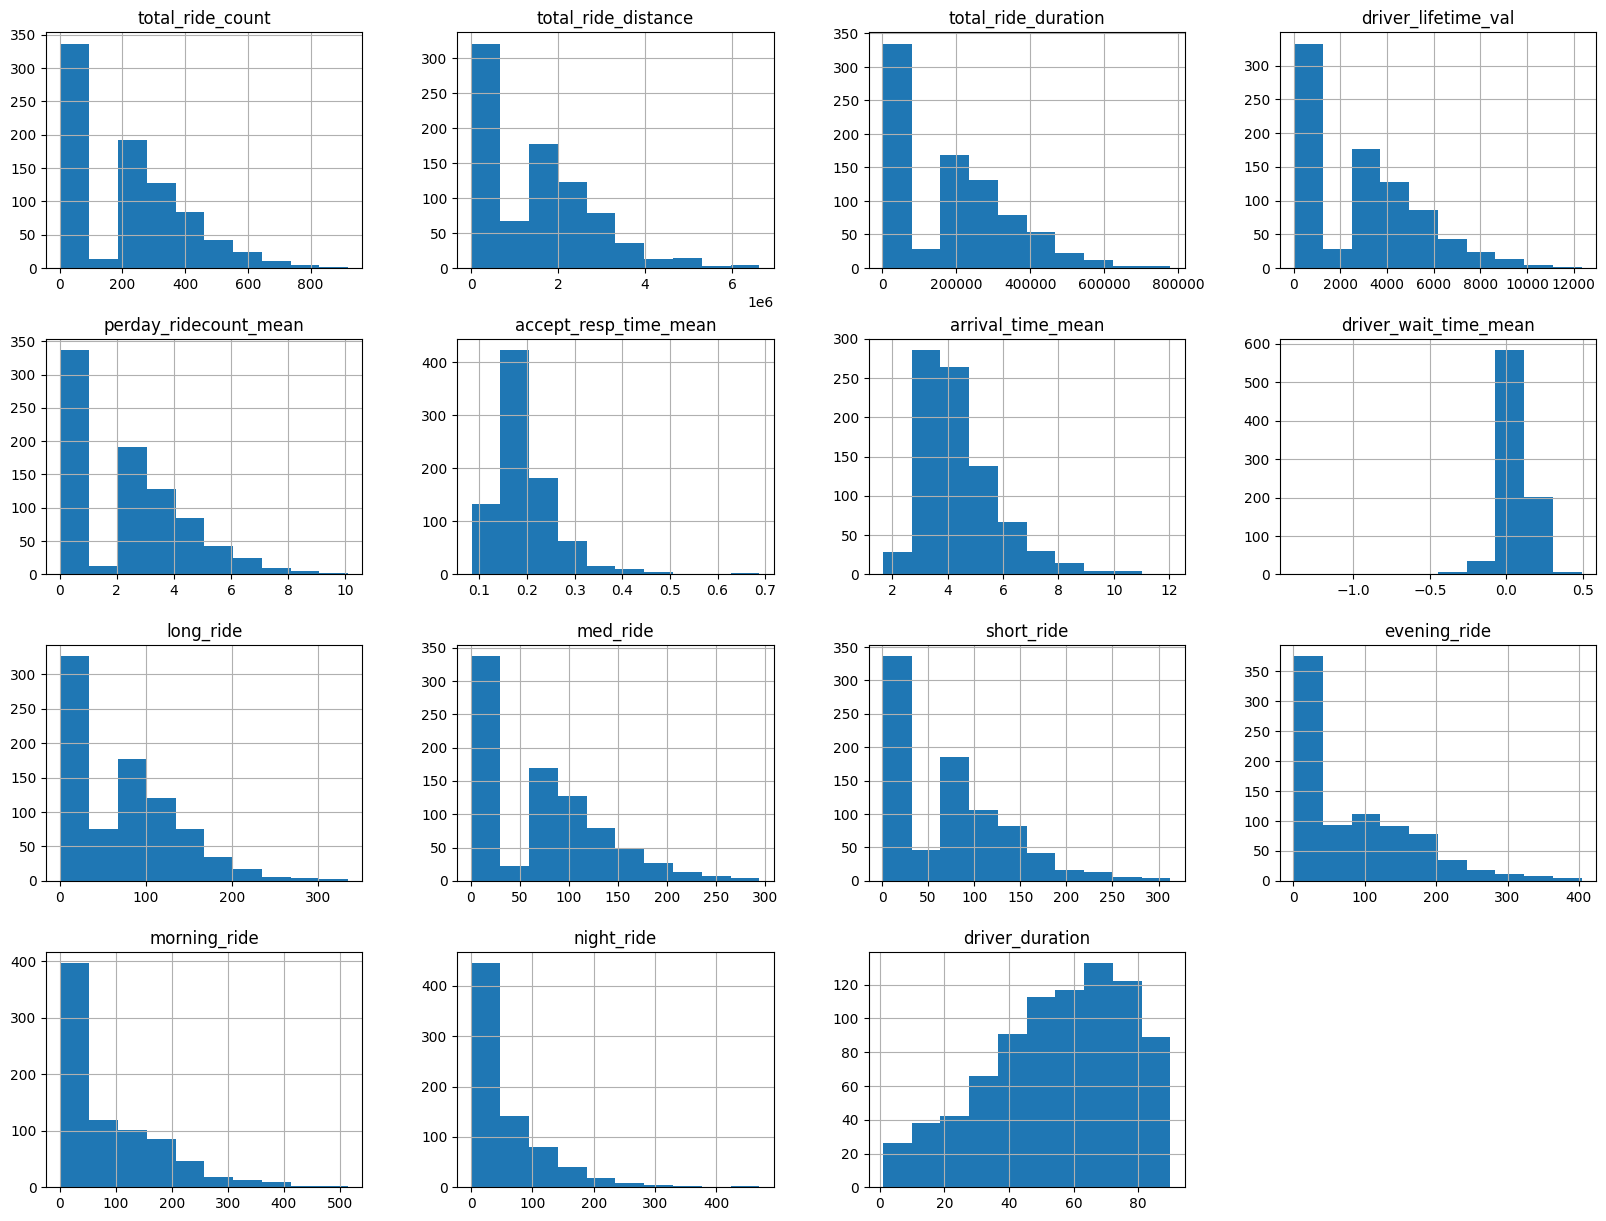

In [ ]:
#plot histograms for the above data


driver_info.hist( figsize=(20,15))
plt.show()

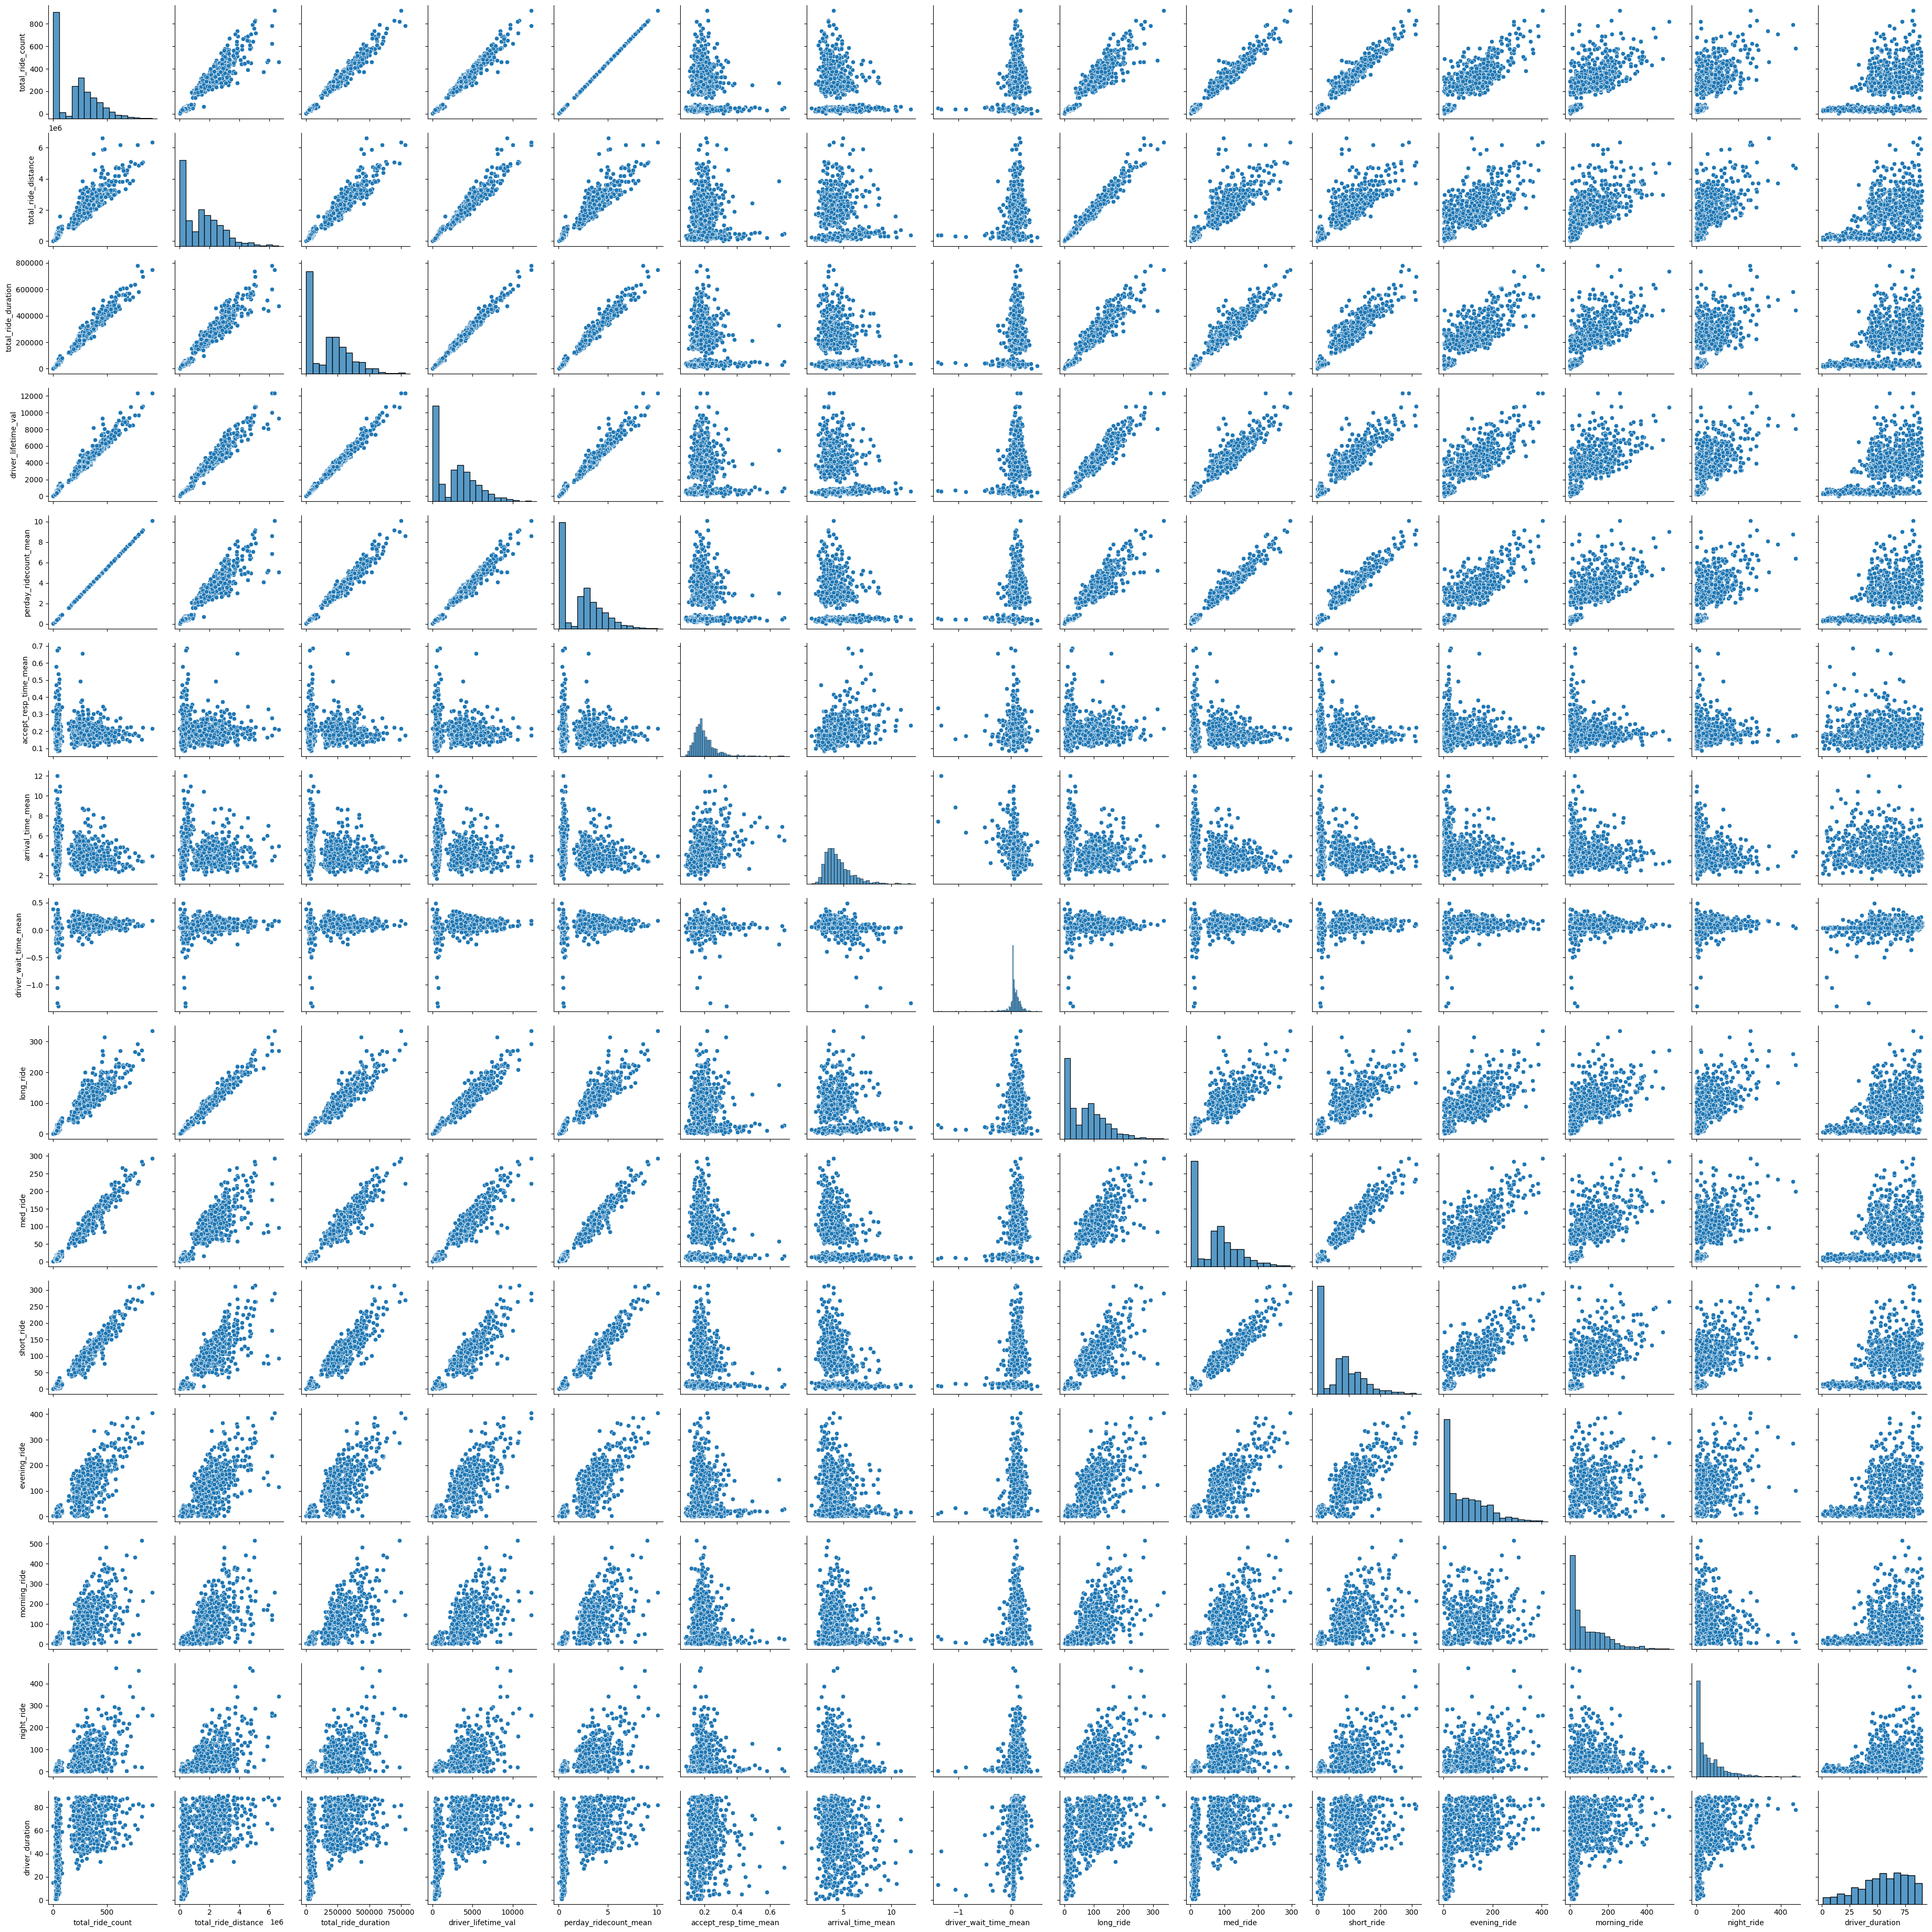

In [ ]:
#scatter plots of data

sns.pairplot(driver_info)

# **Main Factors Affecting a Driver's Lifetime Value**

<ipython-input-38-45d61e5992b1>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(driver_info.corr())


<Axes: >

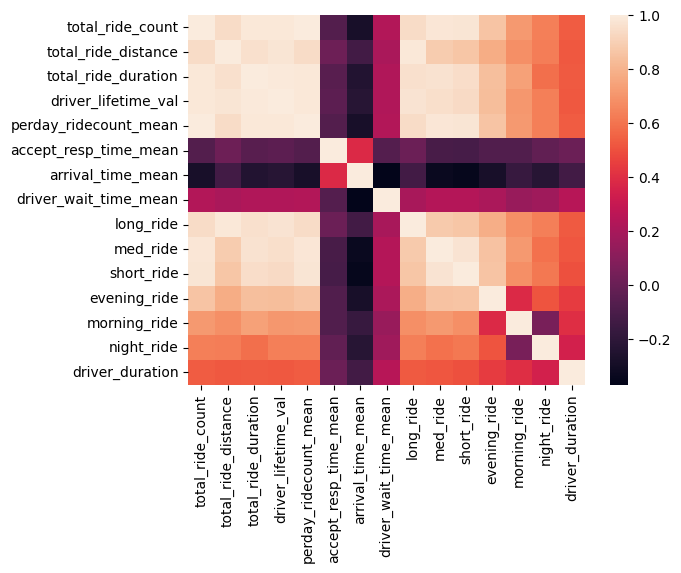

In [ ]:
# plot a heatmap of correlations betweem features


sns.heatmap(driver_info.corr())





In [ ]:
# get a correlation with lifetime_value as a DataFrame sorted in descending order

pd.DataFrame(driver_info.corr()['driver_lifetime_val']).sort_values(ascending=False, by='driver_lifetime_val'  )



<ipython-input-39-c3d4d05dda55>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.DataFrame(driver_info.corr()['driver_lifetime_val']).sort_values(ascending=False, by='driver_lifetime_val'  )


driver_lifetime_val
driver_lifetime_val               1.000000
total_ride_duration               0.994194
total_ride_count                  0.987069
perday_ridecount_mean             0.987069
total_ride_distance               0.978453
long_ride                         0.971439
med_ride                          0.954142
short_ride                        0.940301
evening_ride                      0.838266
morning_ride                      0.709886
night_ride                        0.636137
driver_duration                   0.523453
driver_wait_time_mean             0.226387
accept_resp_time_mean            -0.040457
arrival_time_mean                -0.228554

# Average Projected Lifetime of a Driver

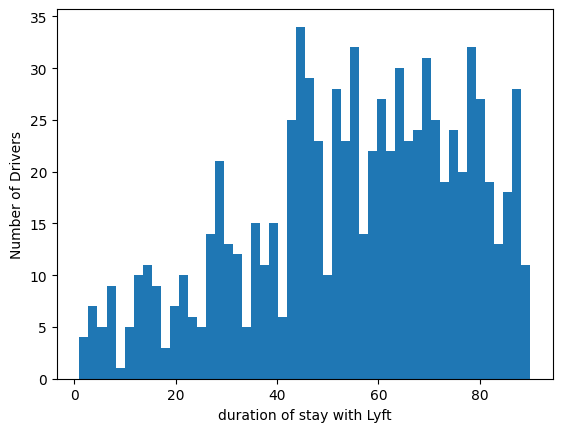

In [ ]:
driver_info['driver_duration'].plot.hist(bins=50)
plt.xlabel('duration of stay with Lyft')
plt.ylabel('Number of Drivers')
plt.show()

In [ ]:
driver_info['driver_duration'].describe()


count    837.000000
mean      55.075269
std       21.721934
min        1.000000
25%       42.000000
50%       57.000000
75%       73.000000
max       90.000000
Name: driver_duration, dtype: float64

From above analysis we can see that average time a driver stays with uber is 55 days.

# Do All Drivers Act Alike? - Clustering Exercise

In [ ]:
driver_info.head()

driver_id  total_ride_count  total_ride_distance  \
0  002be0ffdc997bd5c50703158b7c2491               277              1740287   
1  007f0389f9c7b03ef97098422f902e62                31               117531   
2  011e5c5dfc5c2c92501b8b24d47509bc                34               269653   
3  0152a2f305e71d26cc964f8d4411add9               191              1471239   
4  01674381af7edd264113d4e6ed55ecda               375              3123644   

   total_ride_duration  driver_lifetime_val  perday_ridecount_mean  \
0               221238          3560.058574               3.043956   
1                20497           321.434883               0.340659   
2                29205           482.299458               0.373626   
3               174521          2610.190490               2.098901   
4               357443          5379.647779               4.120879   

   accept_resp_time_mean  arrival_time_mean  driver_wait_time_mean  long_ride  \
0               0.140132           2.883153               0.087184         79   
1               0.197312           2.952688               0.081183          5   
2               0.121569           3.720588               0.068137         11   
3               0.236649           3.908813               0.091885         99   
4               0.208800           3.608133               0.136800        157   

   med_ride  short_ride  evening_ride  morning_ride  night_ride  \
0       103          95         103.0          85.0        89.0   
1        15          11          24.0           6.0         1.0   
2        11          12          24.0           8.0         2.0   
3        51          41          17.0          67.0       107.0   
4       111         107           NaN         350.0        25.0   

   driver_duration  
0             86.0  
1             85.0  
2             68.0  
3             64.0  
4             56.0

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Use the KElbowVisualizer to determine the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(driver_info.drop(['driver_id'], axis=1))
visualizer.show()

ValueError: ignored

In [ ]:
# Fit a K-Means model with the optimal number of clusters
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans.fit(driver_info.drop(['driver_id'], axis=1))

InvalidParameterError: ignored